**Data Input**

In [ ]:
import csv
import numpy as np
np.set_printoptions(suppress=True)

def remove_duplicate_delimiter(f, delimiter):
  for line in f:
    yield delimiter.join(field for field in line.split(delimiter) if field)

with open('seeds_dataset.txt', newline='') as csv_file:
    seeds = np.asarray(list(csv.reader(remove_duplicate_delimiter(csv_file, '\t'), delimiter='\t')))

with open('ionosphere.data', newline='') as csv_file:
    ionosphere = np.asarray(list(csv.reader(csv_file, delimiter=',')))

**Shuffle the data**

In [ ]:
np.random.shuffle(seeds)
np.random.shuffle(ionosphere)

**Support Vector Machine**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ionosphere[:,0:-1], ionosphere[:,-1], test_size=0.3)

**Question-Show the average performance of K-fold cross-validation of parameter search in tables for each kernel**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Set the parameters by cross-validation
poly_parameters = [
    {"coef0": [0, 1, 10], "gamma": [1e-3, 1e-4, 1e-5], "degree": [3, 5, 7]},
]

rbf_parameters = [
    {"gamma": [1e-3, 1e-4, 1e-5]},
]

**linear kernel**

In [ ]:
model = SVC(C=1, kernel='linear', tol=1e-6)
model.fit(x_train, y_train)
print('Confusion matrix')
y_pred = model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Confusion matrix
[[20 18]
 [ 2 66]]
              precision    recall  f1-score   support

           b       0.91      0.53      0.67        38
           g       0.79      0.97      0.87        68

    accuracy                           0.81       106
   macro avg       0.85      0.75      0.77       106
weighted avg       0.83      0.81      0.80       106



**polynomial kernel**

In [ ]:
model = GridSearchCV(SVC(C=100, kernel='poly', tol=1e-6), poly_parameters, scoring='accuracy', cv=5)
model.fit(x_train, y_train)
print("Best parameters set found on development set:")
print()
print(model.best_params_)
print()
print('Confusion matrix')
y_pred = model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print()
print(pd.DataFrame({'parameters': model.cv_results_['params'], 'average performance': model.cv_results_['mean_test_score']}))

Best parameters set found on development set:

{'coef0': 10, 'degree': 3, 'gamma': 0.0001}

Confusion matrix
[[20 18]
 [ 4 64]]
              precision    recall  f1-score   support

           b       0.83      0.53      0.65        38
           g       0.78      0.94      0.85        68

    accuracy                           0.79       106
   macro avg       0.81      0.73      0.75       106
weighted avg       0.80      0.79      0.78       106


                                     parameters  average performance
0     {'coef0': 0, 'degree': 3, 'gamma': 0.001}             0.640816
1    {'coef0': 0, 'degree': 3, 'gamma': 0.0001}             0.640816
2     {'coef0': 0, 'degree': 3, 'gamma': 1e-05}             0.640816
3     {'coef0': 0, 'degree': 5, 'gamma': 0.001}             0.640816
4    {'coef0': 0, 'degree': 5, 'gamma': 0.0001}             0.640816
5     {'coef0': 0, 'degree': 5, 'gamma': 1e-05}             0.640816
6     {'coef0': 0, 'degree': 7, 'gamma': 0.001}             0

**RBF kernel**

In [ ]:
model = GridSearchCV(SVC(C=1000, kernel='rbf', tol=1e-6), rbf_parameters, scoring='accuracy', cv=5)
model.fit(x_train, y_train)
print("Best parameters set found on development set:")
print()
print(model.best_params_)
print()
print('Confusion matrix')
y_pred = model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print()
print(pd.DataFrame({'parameters': model.cv_results_['params'], 'average performance': model.cv_results_['mean_test_score']}))


Best parameters set found on development set:

{'gamma': 0.001}

Confusion matrix
[[25 13]
 [ 3 65]]
              precision    recall  f1-score   support

           b       0.89      0.66      0.76        38
           g       0.83      0.96      0.89        68

    accuracy                           0.85       106
   macro avg       0.86      0.81      0.82       106
weighted avg       0.85      0.85      0.84       106


          parameters  average performance
0   {'gamma': 0.001}             0.918367
1  {'gamma': 0.0001}             0.869388
2   {'gamma': 1e-05}             0.877551


**Results**

| ionosphere        | Sensitivity(Recall) | Precision | Accuracy |
|-------------------|:-------------------:|:---------:|:--------:|
| linear kernel     | 0.97                | 0.79      | 0.81     |
| polynomial kernel | 0.94                | 0.78      | 0.79     |
| RBF kernel        | 0.96                | 0.83      | 0.85     |

**Transform data format and shape - seeds**<br>
Use Principal Component Analysis to reduce feature to 2 dimension

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

x = PCA(n_components=2).fit_transform(seeds[:,0:-1].astype('float64'))
y = seeds[:,-1].astype('int')

**K-means Clustering**

In [ ]:
class KMeans:
  def __init__(self, n_cluster):
    self.n_cluster = n_cluster
  
  def fit(self, X):
    centers = self._init_centroids(X).astype('float64')

    # stopping criterion
    criterion = 0
    while criterion < 100:
      clusters = np.empty(X.shape[0])
      for i in range(X.shape[0]):
        distances = np.empty(self.n_cluster)
        for j in range(self.n_cluster):
          distances[j] = self._distance_function(X[i], centers[j])
        # assign cluster to the closest center
        clusters[i] = np.argmin(distances)
      
      # update centers
      for i in range(self.n_cluster):
        centers[i] = np.mean(X[np.where(clusters==i)], axis=0)
      criterion += 1
    
    self.centers = centers
  
  def _init_centroids(self, X):
    _X = np.copy(X)
    np.random.shuffle(_X)
    return _X[0:self.n_cluster]

  def _distance_function(self, a, b):
    return np.linalg.norm(a - b)

  # return the index of cluster
  def predict(self, Y):
    clusters = np.empty(Y.shape[0])
    for i in range(Y.shape[0]):
      distances = np.empty(self.n_cluster)
      for j in range(self.n_cluster):
        distances[j] = self._distance_function(Y[i], self.centers[j])
      # assign cluster to the closest center
      clusters[i] = np.argmin(distances)
    
    return clusters

  def centers(self):
    return self.centers

In [ ]:
model = KMeans(n_cluster=3)
model.fit(x)
pred = model.predict(x) + 1
print('Confusion matrix')
print(confusion_matrix(y, pred))
print(classification_report(y, pred))

Confusion matrix
[[60  1  9]
 [10 60  0]
 [ 2  0 68]]
              precision    recall  f1-score   support

           1       0.83      0.86      0.85        70
           2       0.98      0.86      0.92        70
           3       0.88      0.97      0.93        70

    accuracy                           0.90       210
   macro avg       0.90      0.90      0.90       210
weighted avg       0.90      0.90      0.90       210



**Question - Choose two features to execute your K-means function and draw a scatter plot with the computed centers and the predicted label for each instance**

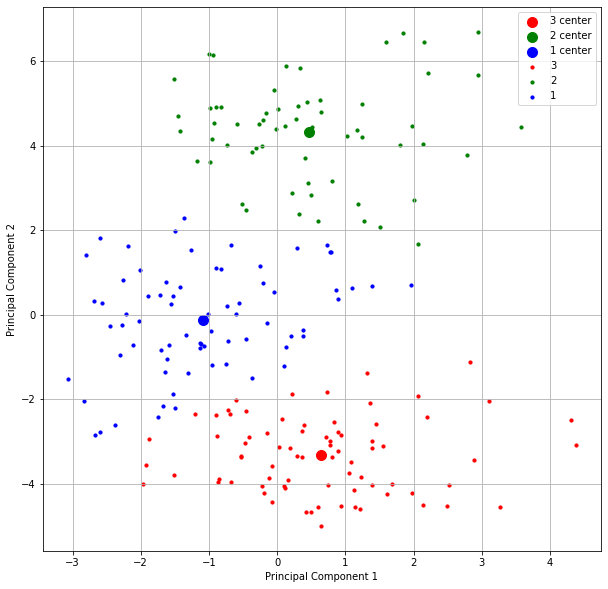

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

targets = [3, 2, 1]
colors = ['r', 'g', 'b']

for target, color in zip(targets,colors):
  plt.scatter(model.centers[target-1,1], model.centers[target-1,0], s=100, label=str(target) + ' center', c=color)

for target, color in zip(targets,colors):
  index = np.where(pred==target)
  plt.scatter(x[index,1], x[index,0], s=10, label=target, c=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()